In [3]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Fragments
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
rdBase.DisableLog('rdApp.error')

In [4]:
def replace_atom(mol):
    res = []
    aro_idxs = [atom.GetIdx() for atom in mol.GetAromaticAtoms() if atom.GetDegree() < 3]
    for atm_num in [6, 7, 8, 16]:
        for idx in aro_idxs:
            cp_mol = copy.deepcopy(mol)
            cp_mol.GetAtomWithIdx(idx).SetAtomicNum(atm_num)
            p = Chem.MolFromSmarts("nnn")
            if cp_mol.HasSubstructMatch(p) != True:
                try:
                    smi = Chem.MolToSmiles(cp_mol)
                    smi.replace("[sH]", "s")
                    cp_mol = Chem.MolFromSmiles(smi)
                    Chem.SanitizeMol(cp_mol)
                    res.append(cp_mol)
                except:
                    pass
    return res
 
def recursive_replace(mols, check=set([]), thres=0.4):
    before_n = len(check)
    print(before_n)
    for mol in mols:
        replaced_mols = replace_atom(mol)
        for mol_conv in replaced_mols:
            aro_n = Fragments.fr_Ar_N(mol)
            aro_a = len(mol.GetAromaticAtoms())
            ratio = float(aro_n) / float(aro_a)
            if ratio < thres:
                smi = Chem.MolToSmiles(mol_conv)
                check.add(smi)
    after_n = len(check)
    print(before_n, after_n)
    if before_n < after_n:
        mols = [Chem.MolFromSmiles(mol) for mol in check]
        recursive_replace(mols, check=check)
    return [Chem.MolFromSmiles(smi) for smi in check]

In [5]:
# Gefitinib
mol1 = Chem.MolFromSmiles('COC1=C(C=C2C(=C1)N=CN=C2NC3=CC(=C(C=C3)F)Cl)OCCCN4CCOCC4')
#  Oxaprozin
mol2 = Chem.MolFromSmiles('C1=CC=C(C=C1)C2=C(OC(=N2)CCC(=O)O)C3=CC=CC=C3')

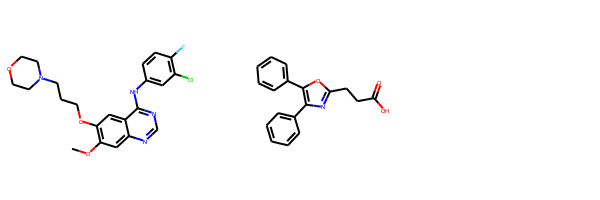

In [6]:
Draw.MolsToGridImage([mol1, mol2])

In [8]:
res = recursive_replace([mol1])

0
0 8
8
8 31
31
31 77
77
77 137
137
137 188
188
188 215
215
215 223
223
223 224
224
224 224


/Users/iwatobipen/.pyenv/versions/anaconda3-5.1.0/envs/py36/lib/python3.6/site-packages/rdkit/Chem/Draw/IPythonConsole.py:183: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


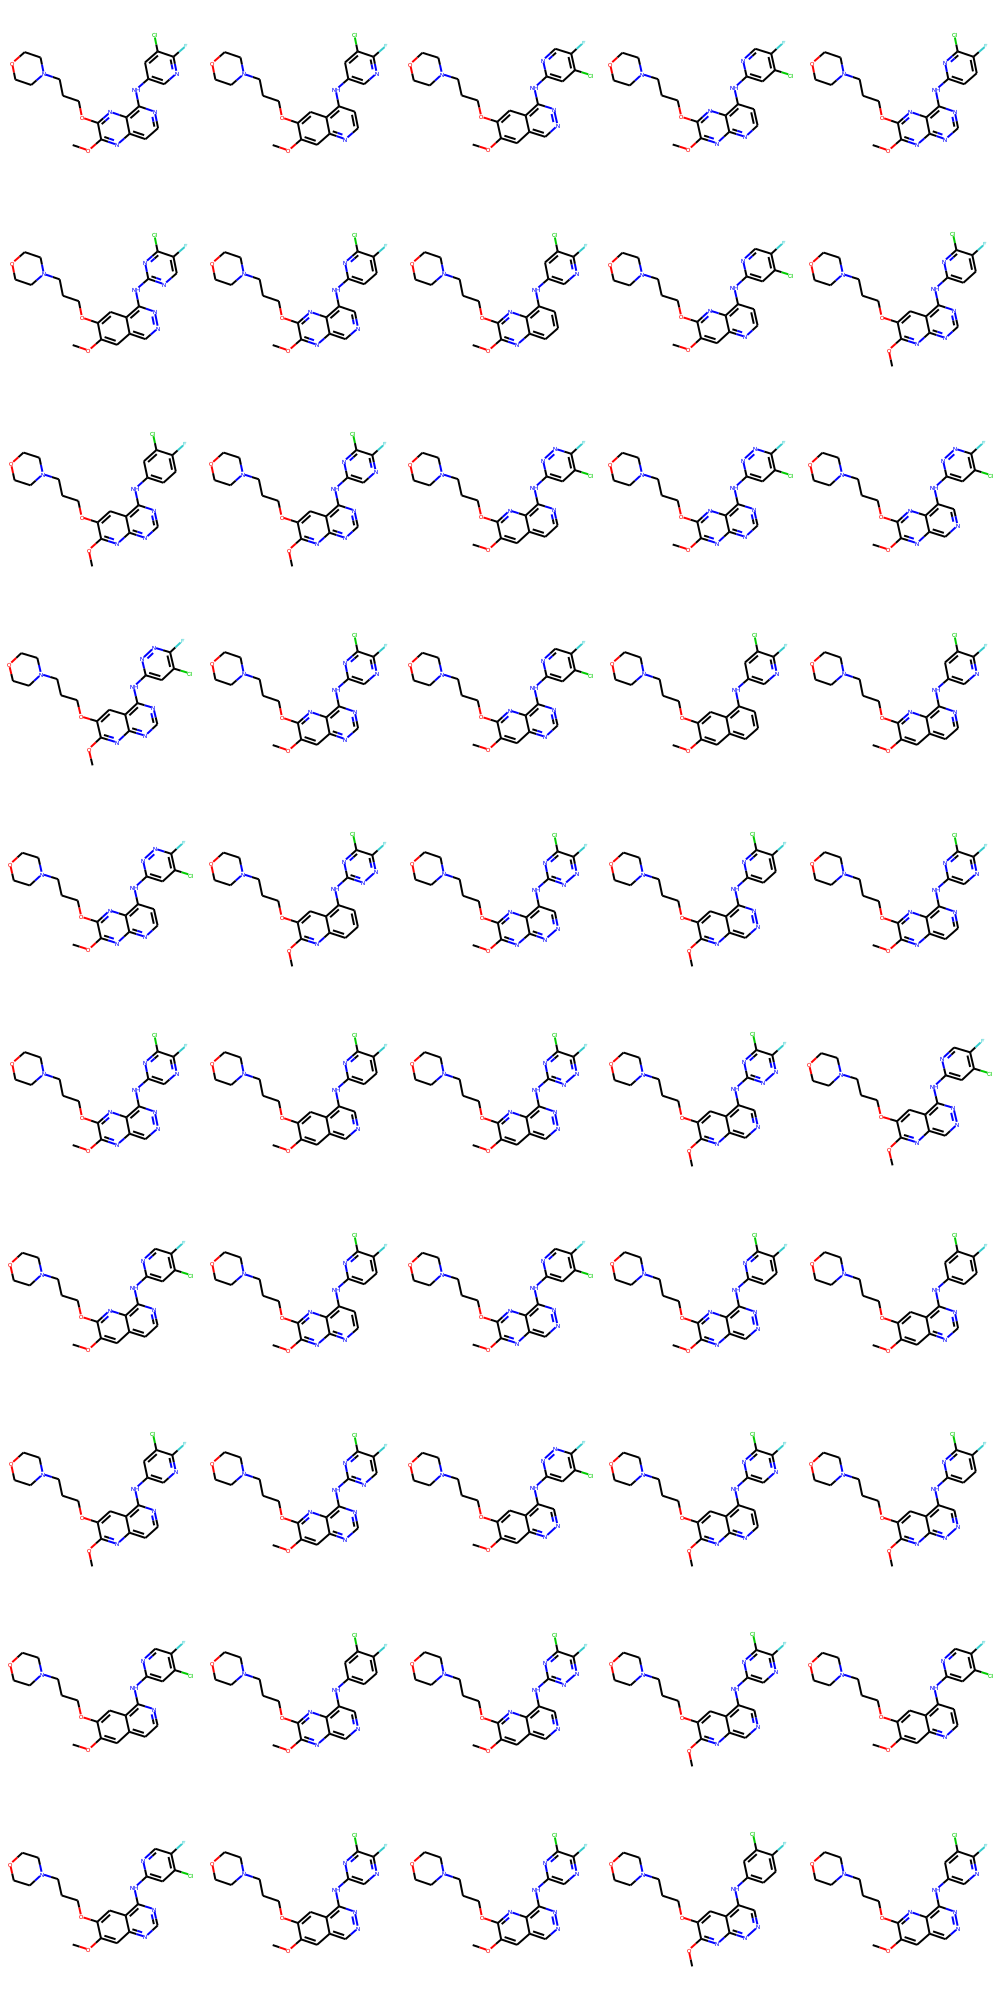

In [9]:
Draw.MolsToGridImage(res, molsPerRow=5)

224
224 233
233
233 267
267
267 359
359
359 530
530
530 752
752
752 950
950
950 1060
1060
1060 1096
1096
1096 1104
1104
1104 1104


/Users/iwatobipen/.pyenv/versions/anaconda3-5.1.0/envs/py36/lib/python3.6/site-packages/rdkit/Chem/Draw/IPythonConsole.py:183: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


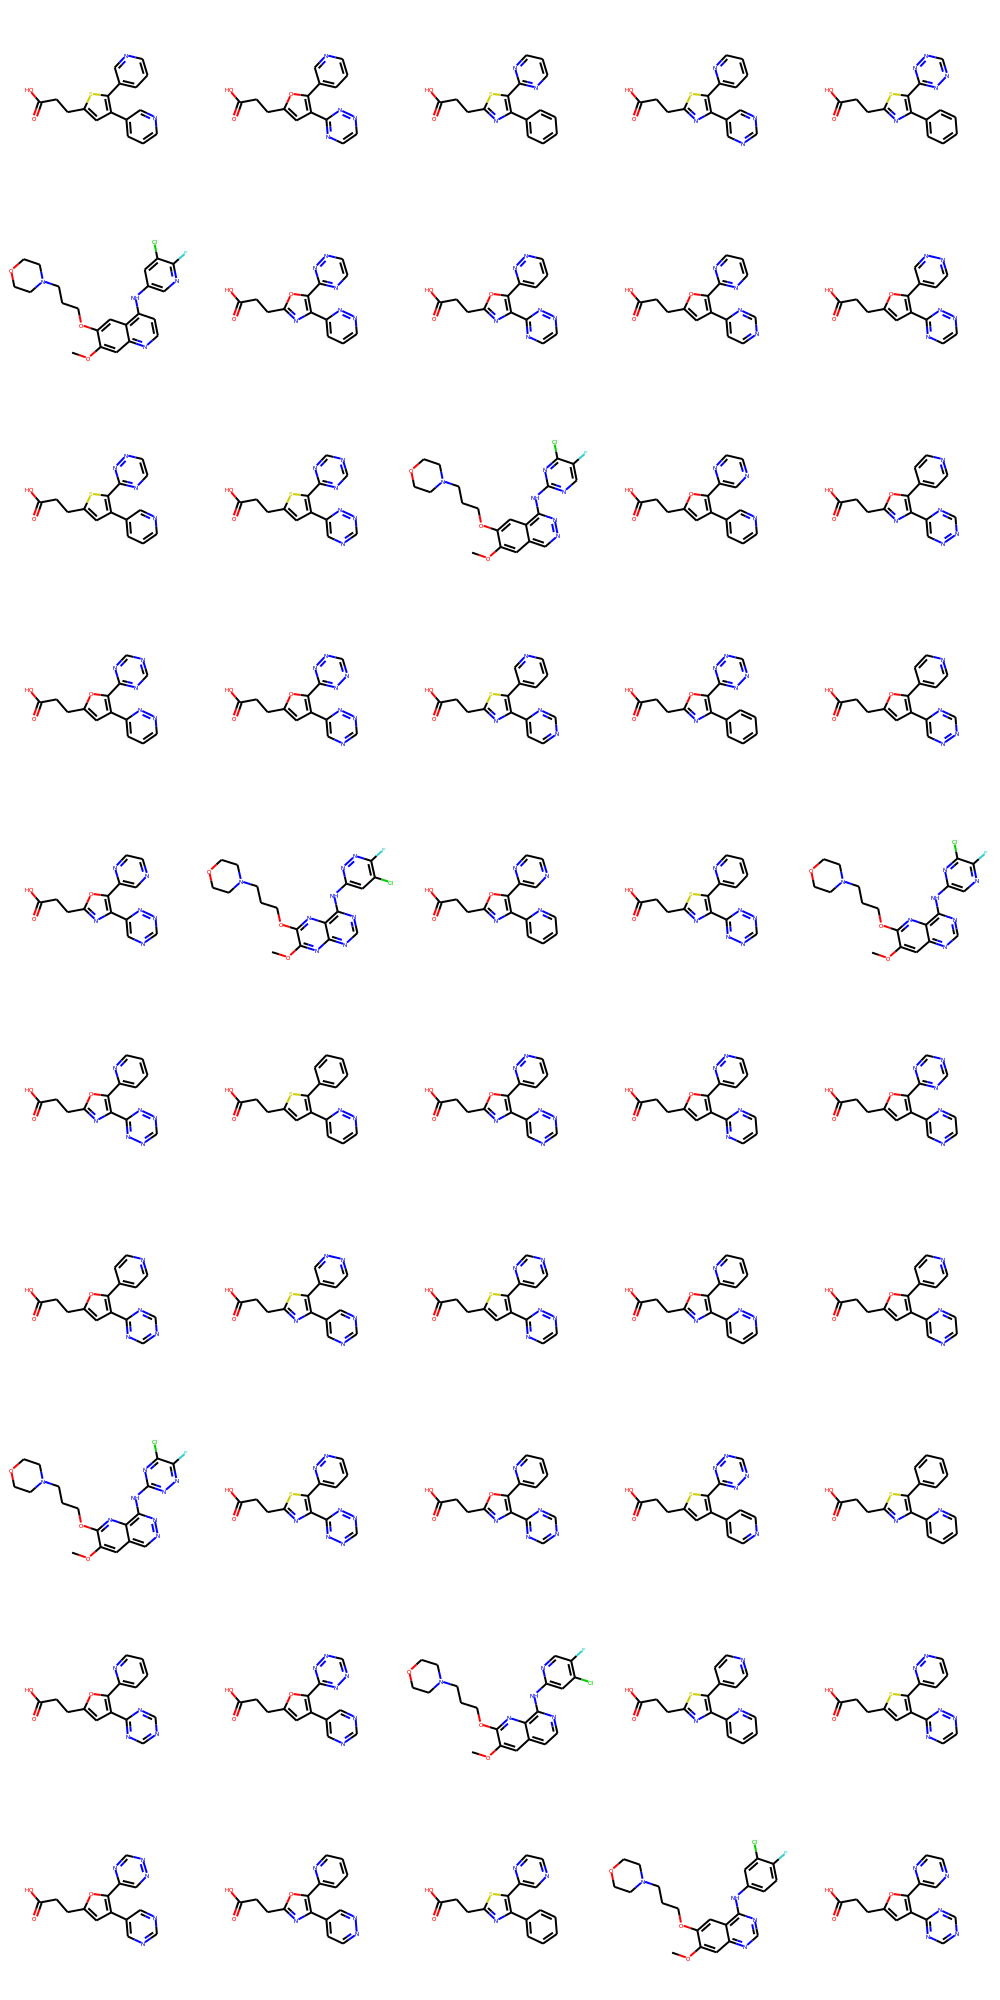

In [10]:
res = recursive_replace([mol2])
Draw.MolsToGridImage(res, molsPerRow=5)